In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.experimental import enable_iterative_imputer
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from lightgbm import LGBMRegressor

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, mean_absolute_error, r2_score


In [3]:
df = pd.read_csv("loan_data_v3.csv")

In [4]:
df.head()

,Unnamed: 0,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,4847,26.0,male,Associate,43996.0,4,RENT,5000.0,VENTURE,10.37,0.11,4.0,675.0,No,0.0
1,13802,22.0,female,Bachelor,115708.0,0,MORTGAGE,20000.0,EDUCATION,7.88,0.17,3.0,635.0,No,0.0
2,39763,25.0,female,High School,57827.0,0,RENT,6000.0,PERSONAL,11.60,0.10,4.0,589.0,Yes,0.0
3,39215,31.0,female,Master,126727.0,9,RENT,24000.0,DEBTCONSOLIDATION,10.27,0.19,7.0,644.0,Yes,0.0
4,26369,33.0,female,Associate,120987.0,10,OWN,25000.0,MEDICAL,12.18,0.21,10.0,644.0,Yes,0.0


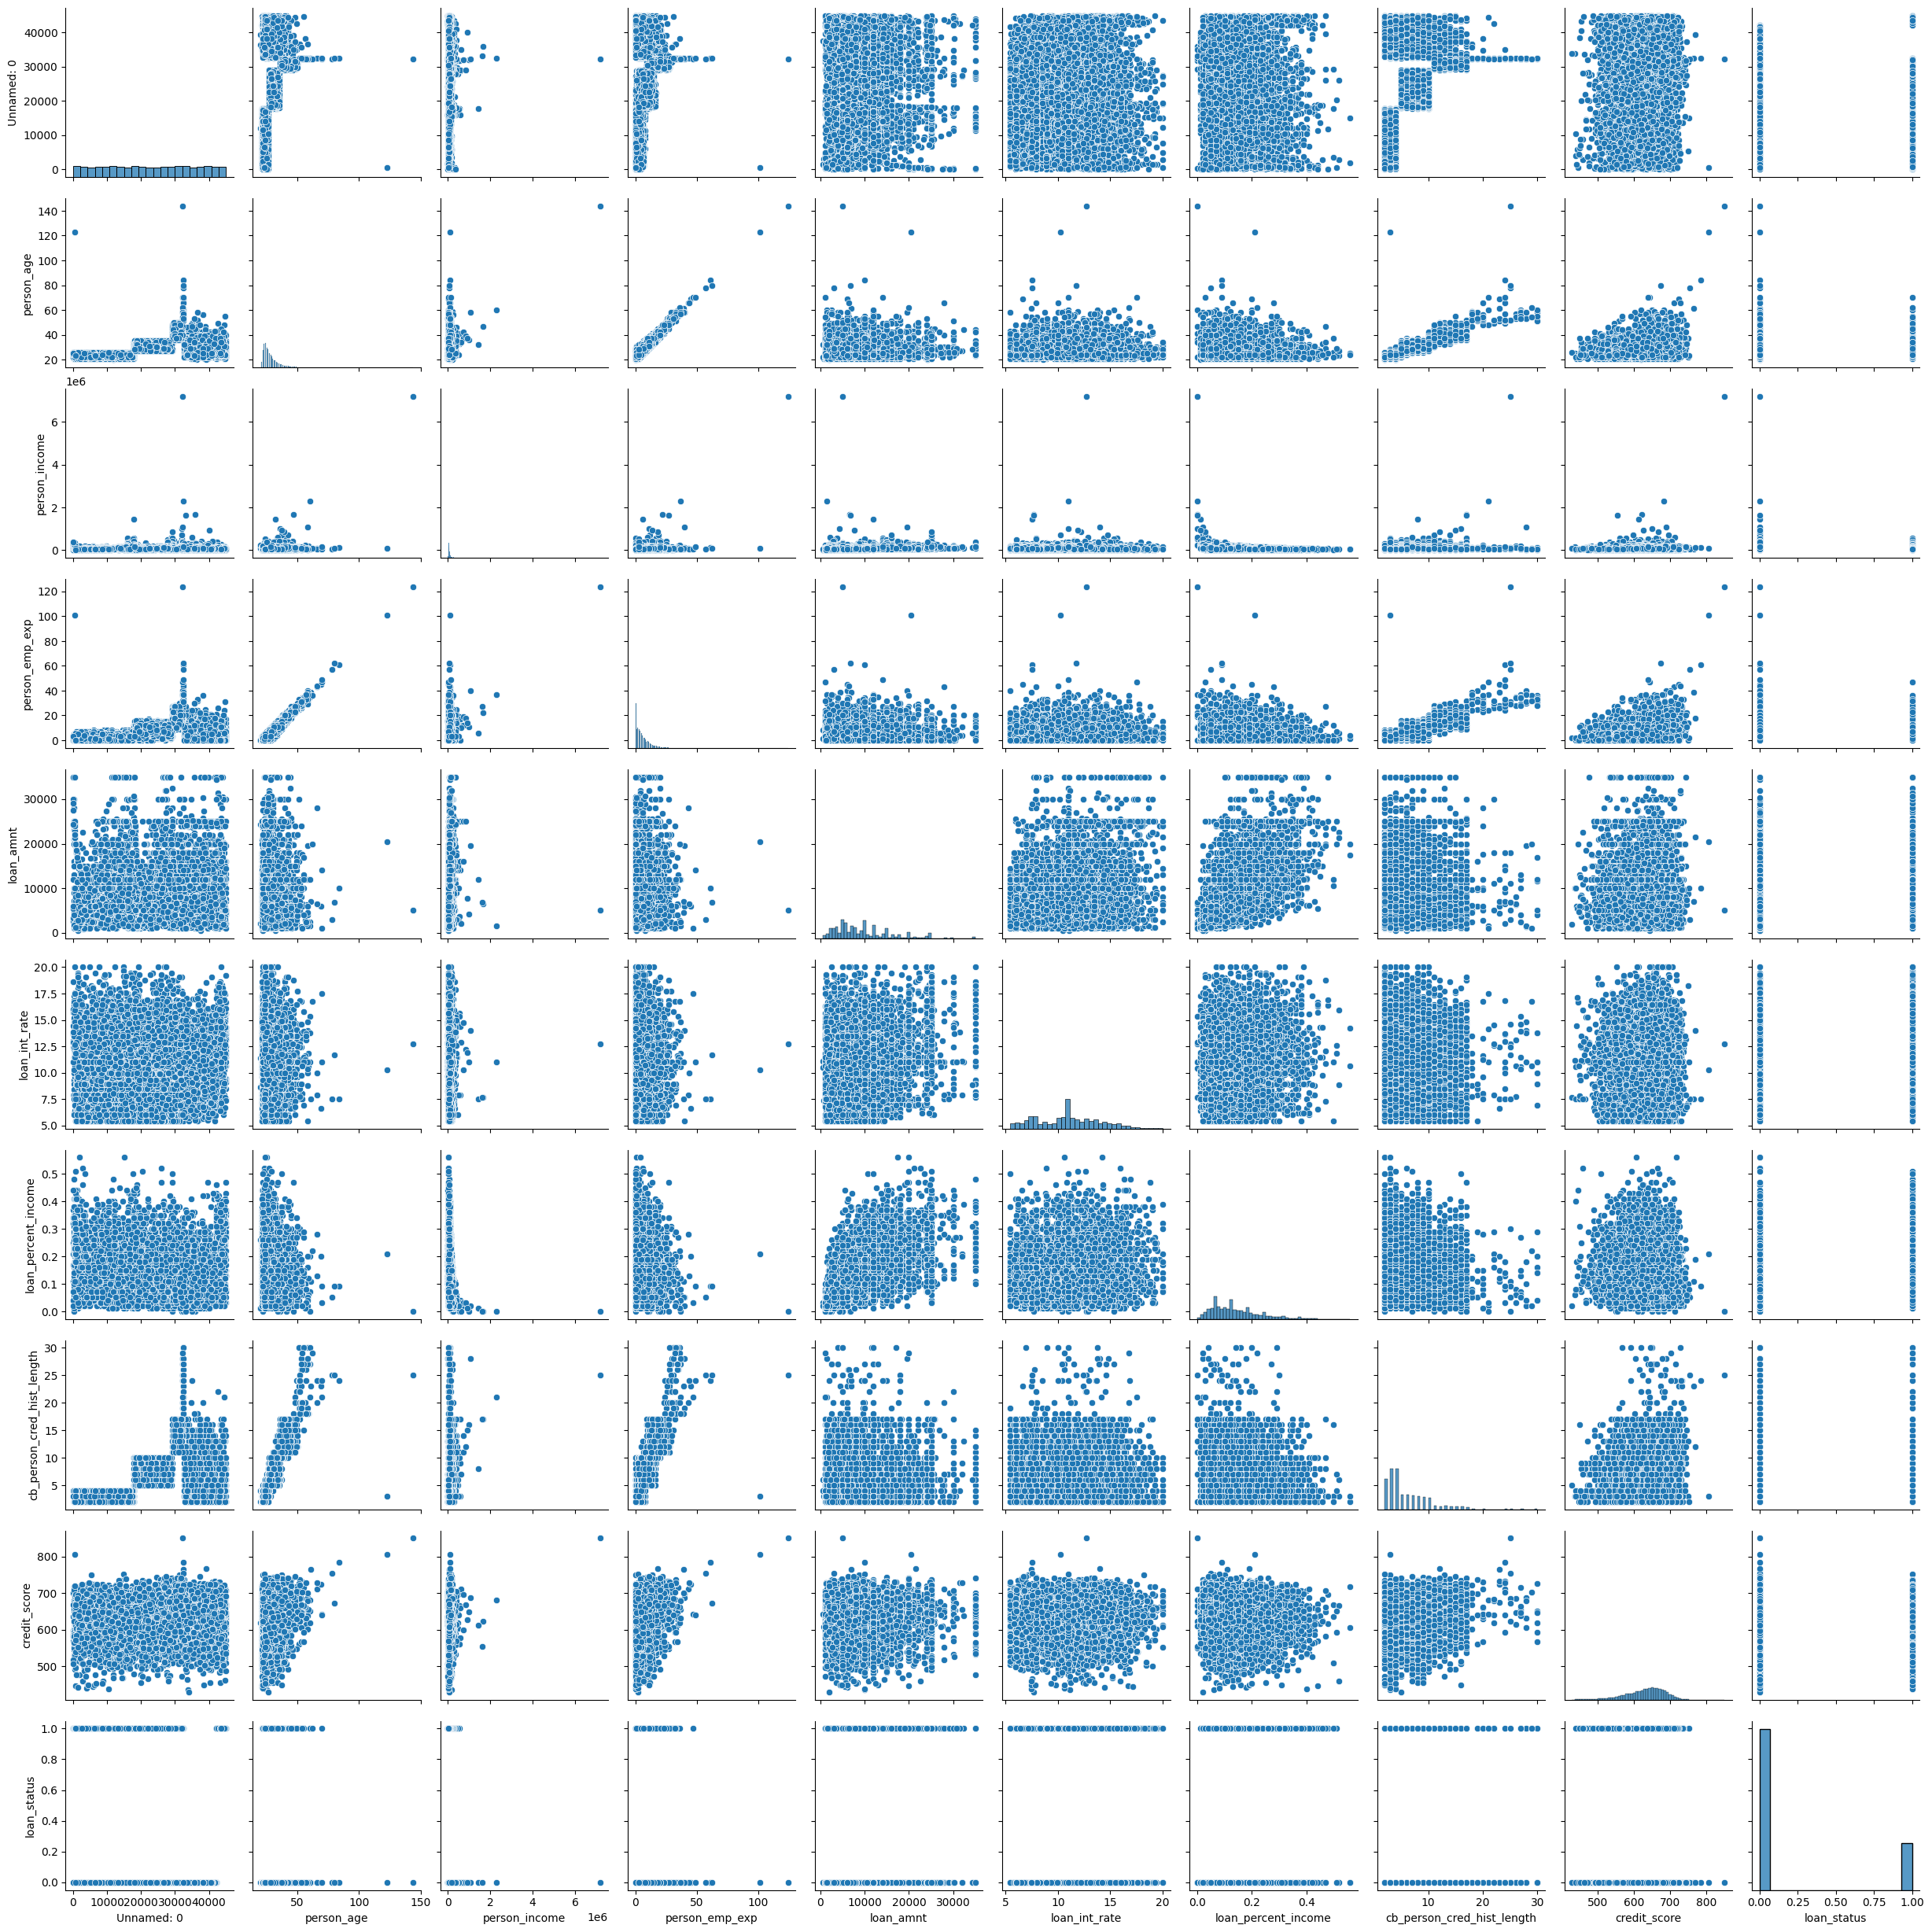

In [5]:
sns.pairplot(df)

<Axes: >

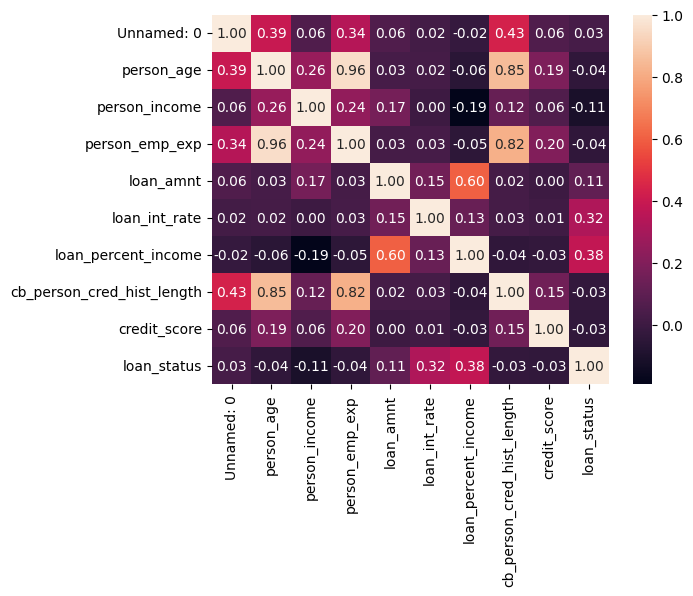

In [8]:
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt='.2f')

In [9]:
df.drop(columns=["Unnamed: 0"], inplace=True)

In [10]:
df.sample()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
24,25.0,male,Associate,76329.0,5,RENT,2400.0,DEBTCONSOLIDATION,7.14,0.03,4.0,651.0,No,0.0


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      7512 non-null   float64
 1   person_gender                   7706 non-null   object 
 2   person_education                7578 non-null   object 
 3   person_income                   8000 non-null   float64
 4   person_emp_exp                  8000 non-null   int64  
 5   person_home_ownership           8000 non-null   object 
 6   loan_amnt                       7664 non-null   float64
 7   loan_intent                     8000 non-null   object 
 8   loan_int_rate                   8000 non-null   float64
 9   loan_percent_income             8000 non-null   float64
 10  cb_person_cred_hist_length      8000 non-null   float64
 11  credit_score                    7478 non-null   float64
 12  previous_loan_defaults_on_file  80

In [12]:
df.drop(columns=["person_emp_exp"], inplace=True)

In [13]:
df.drop(columns=["cb_person_cred_hist_length"], inplace=True)

In [14]:
df.sample()

,person_age,person_gender,person_education,person_income,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,credit_score,previous_loan_defaults_on_file,loan_status
5485,23.0,female,High School,43058.0,RENT,3000.0,PERSONAL,13.85,0.07,635.0,Yes,0.0


In [26]:
df.isnull().sum()

person_age                        488
person_gender                     294
person_education                  422
person_income                       0
person_home_ownership               0
loan_amnt                         336
loan_intent                         0
loan_int_rate                       0
loan_percent_income                 0
credit_score                      522
previous_loan_defaults_on_file      0
loan_status                       250
dtype: int64

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      7512 non-null   float64
 1   person_gender                   7706 non-null   float64
 2   person_education                7578 non-null   float64
 3   person_income                   8000 non-null   float64
 4   person_home_ownership           8000 non-null   object 
 5   loan_amnt                       7664 non-null   float64
 6   loan_intent                     8000 non-null   object 
 7   loan_int_rate                   8000 non-null   float64
 8   loan_percent_income             8000 non-null   float64
 9   credit_score                    7478 non-null   float64
 10  previous_loan_defaults_on_file  8000 non-null   object 
 11  loan_status                     7750 non-null   float64
dtypes: float64(9), object(3)
memory us

In [17]:
df["person_gender"] = df["person_gender"].map({"male": 0, "female": 1})

In [20]:
df["person_education"].value_counts()

person_education
Bachelor       2234
Associate      2051
High School    2017
Master         1172
Doctorate       104
Name: count, dtype: int64

In [25]:
df["person_education"] = OrdinalEncoder(categories=[["High School", "Associate", "Bachelor", "Master", "Doctorate", np.nan]]).fit_transform(df[["person_education"]])

In [28]:
df["person_home_ownership"].unique()

array(['RENT', 'MORTGAGE', 'OWN', 'OTHER'], dtype=object)

In [29]:
df = pd.concat([df, pd.get_dummies(df["person_home_ownership"])], axis=1)
df.drop(columns=["person_home_ownership"], inplace=True)

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      7512 non-null   float64
 1   person_gender                   7706 non-null   float64
 2   person_education                7578 non-null   float64
 3   person_income                   8000 non-null   float64
 4   loan_amnt                       7664 non-null   float64
 5   loan_intent                     8000 non-null   object 
 6   loan_int_rate                   8000 non-null   float64
 7   loan_percent_income             8000 non-null   float64
 8   credit_score                    7478 non-null   float64
 9   previous_loan_defaults_on_file  8000 non-null   object 
 10  loan_status                     7750 non-null   float64
 11  MORTGAGE                        8000 non-null   bool   
 12  OTHER                           80

In [31]:
df["loan_intent"].unique()

array(['VENTURE', 'EDUCATION', 'PERSONAL', 'DEBTCONSOLIDATION', 'MEDICAL',
       'HOMEIMPROVEMENT'], dtype=object)

In [32]:
df = pd.concat([df, pd.get_dummies(df["loan_intent"])], axis=1)
df.drop(columns=["loan_intent"], inplace=True)

In [33]:
df["previous_loan_defaults_on_file"].unique()

array(['No', 'Yes'], dtype=object)

In [34]:
df["previous_loan_defaults_on_file"] = df["previous_loan_defaults_on_file"].map({"No": 0, "Yes": 1})

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      7512 non-null   float64
 1   person_gender                   7706 non-null   float64
 2   person_education                7578 non-null   float64
 3   person_income                   8000 non-null   float64
 4   loan_amnt                       7664 non-null   float64
 5   loan_int_rate                   8000 non-null   float64
 6   loan_percent_income             8000 non-null   float64
 7   credit_score                    7478 non-null   float64
 8   previous_loan_defaults_on_file  8000 non-null   int64  
 9   loan_status                     7750 non-null   float64
 10  MORTGAGE                        8000 non-null   bool   
 11  OTHER                           8000 non-null   bool   
 12  OWN                             80

In [36]:
df.head()

,person_age,person_gender,person_education,person_income,loan_amnt,loan_int_rate,loan_percent_income,credit_score,previous_loan_defaults_on_file,loan_status,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
0,26.0,0.0,1.0,43996.0,5000.0,10.37,0.11,675.0,0,0.0,False,False,False,True,False,False,False,False,False,True
1,22.0,1.0,2.0,115708.0,20000.0,7.88,0.17,635.0,0,0.0,True,False,False,False,False,True,False,False,False,False
2,25.0,1.0,0.0,57827.0,6000.0,11.60,0.10,589.0,1,0.0,False,False,False,True,False,False,False,False,True,False
3,31.0,1.0,3.0,126727.0,24000.0,10.27,0.19,644.0,1,0.0,False,False,False,True,True,False,False,False,False,False
4,33.0,1.0,1.0,120987.0,25000.0,12.18,0.21,644.0,1,0.0,False,False,True,False,False,False,False,True,False,False


In [37]:
df.isnull().sum()

person_age                        488
person_gender                     294
person_education                  422
person_income                       0
loan_amnt                         336
loan_int_rate                       0
loan_percent_income                 0
credit_score                      522
previous_loan_defaults_on_file      0
loan_status                       250
MORTGAGE                            0
OTHER                               0
OWN                                 0
RENT                                0
DEBTCONSOLIDATION                   0
EDUCATION                           0
HOMEIMPROVEMENT                     0
MEDICAL                             0
PERSONAL                            0
VENTURE                             0
dtype: int64

<Axes: >

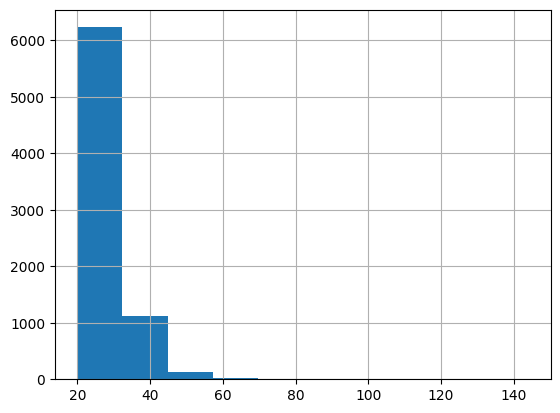

In [38]:
df["person_age"].hist()

In [43]:
simple_imputer = SimpleImputer(strategy="median")
df["person_age"] = simple_imputer.fit_transform(df[["person_age"]])

In [44]:
df.isnull().sum()

person_age                          0
person_gender                     294
person_education                  422
person_income                       0
loan_amnt                         336
loan_int_rate                       0
loan_percent_income                 0
credit_score                      522
previous_loan_defaults_on_file      0
loan_status                       250
MORTGAGE                            0
OTHER                               0
OWN                                 0
RENT                                0
DEBTCONSOLIDATION                   0
EDUCATION                           0
HOMEIMPROVEMENT                     0
MEDICAL                             0
PERSONAL                            0
VENTURE                             0
dtype: int64

<Axes: >

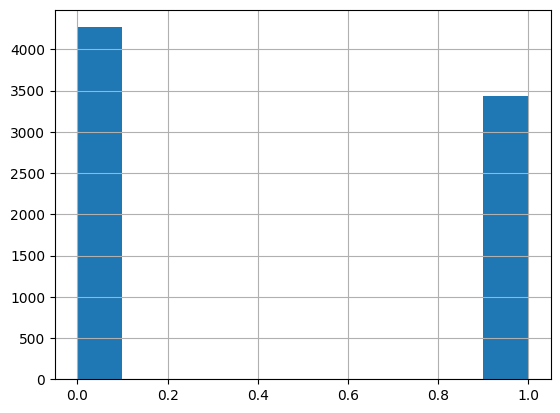

In [45]:
df["person_gender"].hist()

In [47]:
df.drop(columns=["person_gender"],inplace=True)

In [48]:
df.isnull().sum()

person_age                          0
person_education                  422
person_income                       0
loan_amnt                         336
loan_int_rate                       0
loan_percent_income                 0
credit_score                      522
previous_loan_defaults_on_file      0
loan_status                       250
MORTGAGE                            0
OTHER                               0
OWN                                 0
RENT                                0
DEBTCONSOLIDATION                   0
EDUCATION                           0
HOMEIMPROVEMENT                     0
MEDICAL                             0
PERSONAL                            0
VENTURE                             0
dtype: int64

<Axes: >

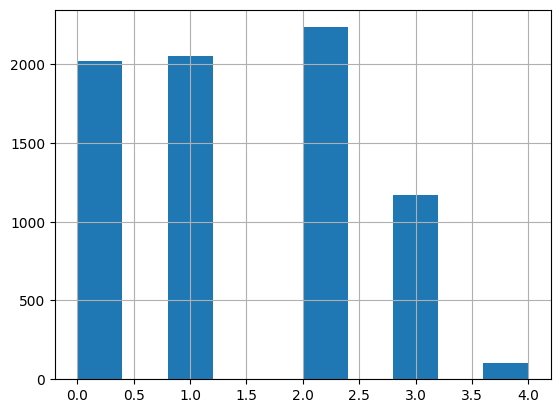

In [49]:
df["person_education"].hist()

In [52]:
imputer= SimpleImputer(strategy="most_frequent")
df["person_education"] = imputer.fit_transform(df[["person_education"]])

In [58]:
df.isnull().sum()

person_age                          0
person_education                    0
person_income                       0
loan_amnt                           0
loan_int_rate                       0
loan_percent_income                 0
credit_score                        0
previous_loan_defaults_on_file      0
loan_status                       250
MORTGAGE                            0
OTHER                               0
OWN                                 0
RENT                                0
DEBTCONSOLIDATION                   0
EDUCATION                           0
HOMEIMPROVEMENT                     0
MEDICAL                             0
PERSONAL                            0
VENTURE                             0
dtype: int64

In [54]:
simple_imputer = SimpleImputer(strategy="median")
df["loan_amnt"] = simple_imputer.fit_transform(df[["loan_amnt"]])

<Axes: >

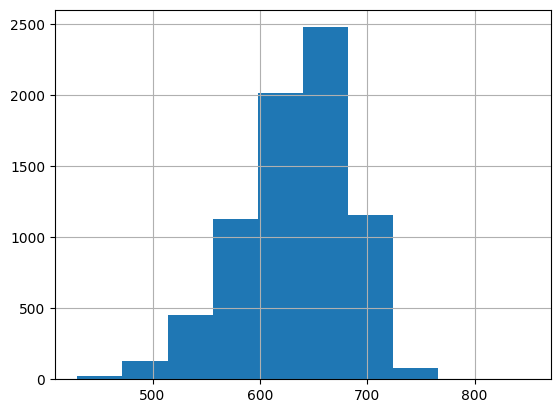

In [56]:
df["credit_score"].hist()

In [57]:
simple_imputer = SimpleImputer(strategy="median")
df["credit_score"] = simple_imputer.fit_transform(df[["credit_score"]])

In [62]:
df = df.dropna(subset=["loan_status"], axis=0)

In [63]:
df.isnull().sum()

person_age                        0
person_education                  0
person_income                     0
loan_amnt                         0
loan_int_rate                     0
loan_percent_income               0
credit_score                      0
previous_loan_defaults_on_file    0
loan_status                       0
MORTGAGE                          0
OTHER                             0
OWN                               0
RENT                              0
DEBTCONSOLIDATION                 0
EDUCATION                         0
HOMEIMPROVEMENT                   0
MEDICAL                           0
PERSONAL                          0
VENTURE                           0
dtype: int64

In [64]:
X, y = df.drop(columns=["loan_status"]), df["loan_status"]

In [65]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [66]:
scaler = MinMaxScaler()

In [67]:
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)

In [68]:
classifier = LogisticRegression()
classifier = classifier.fit(train_X, train_y)
pred_y = classifier.predict(test_X)

In [69]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.94      0.94      0.94      1220
         1.0       0.77      0.77      0.77       330

    accuracy                           0.90      1550
   macro avg       0.85      0.85      0.85      1550
weighted avg       0.90      0.90      0.90      1550



In [75]:
classifier = XGBClassifier().fit(train_X, train_y)

In [70]:
param_grid = {
    "criterion": ["entropy", "gini"],
    "max_depth": [None, 1,2,3,4],
}

In [76]:
grid_search = GridSearchCV(
    classifier,
    param_grid,
    cv=5,
)

In [77]:
grid_search.fit(train_X, train_y)

C:\Users\tales\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [15:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\tales\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [15:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\tales\AppData\Roaming\Python\Python310\site-packages\xgboost\core.py:158: UserWarning: [15:11:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "criterion" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\t

,estimator,"XGBClassifier...ate=None, ...)"
,param_grid,"{'criterion': ['entropy', 'gini'], 'max_depth': [None, 1, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,objective,'binary:logistic'


In [78]:
grid_search.best_params_

{'criterion': 'entropy', 'max_depth': 3}

In [79]:
pred_y = grid_search.predict(test_X)

In [80]:
print(classification_report(test_y, pred_y))

              precision    recall  f1-score   support

         0.0       0.95      0.96      0.95      1220
         1.0       0.84      0.80      0.82       330

    accuracy                           0.92      1550
   macro avg       0.89      0.88      0.89      1550
weighted avg       0.92      0.92      0.92      1550



In [81]:
df.sample()

,person_age,person_education,person_income,loan_amnt,loan_int_rate,loan_percent_income,credit_score,previous_loan_defaults_on_file,loan_status,MORTGAGE,OTHER,OWN,RENT,DEBTCONSOLIDATION,EDUCATION,HOMEIMPROVEMENT,MEDICAL,PERSONAL,VENTURE
5035,28.0,0.0,27221.0,8000.0,6.99,0.29,663.0,0,0.0,False,False,True,False,False,True,False,False,False,False


In [82]:
X, y = df.drop(columns=["loan_amnt"]), df["loan_amnt"]

In [83]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

<Axes: >

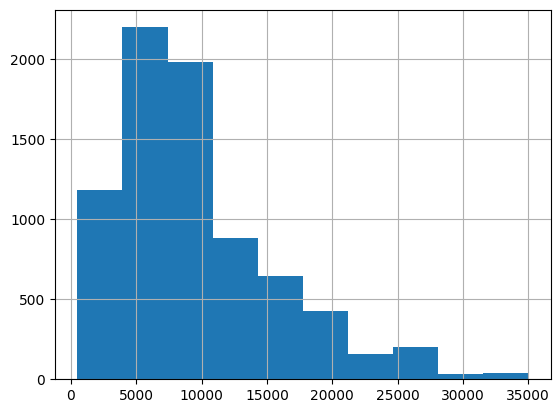

In [84]:
df["loan_amnt"].hist()

In [87]:
df["loan_amnt"].min()


500.0

In [88]:
df["loan_amnt"].max()

35000.0

In [91]:
reg = LinearRegression()
reg = reg.fit(train_X, train_y)
pred_y = reg.predict(test_X)

In [94]:
print("Mean Absolute Error : " + str(mean_absolute_error(pred_y, test_y)))
print("R2 Score : " + str(r2_score(pred_y, test_y)))
print("Mean Squared Error : " + str(mean_squared_error(pred_y, test_y)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(pred_y, test_y))))

Mean Absolute Error : 3108.2423960744354
R2 Score : -0.08311597024124295
Mean Squared Error : 17877746.034144238
Root Mean Squared Error : 4228.208371656278


In [100]:
model = LGBMRegressor(n_estimators=50)
model.fit(train_X, train_y)
pred_y = model.predict(test_X)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 851
[LightGBM] [Info] Number of data points in the train set: 6200, number of used features: 17
[LightGBM] [Info] Start training from score 9419.131613


In [101]:
print("Mean Absolute Error : " + str(mean_absolute_error(pred_y, test_y)))
print("R2 Score : " + str(r2_score(pred_y, test_y)))
print("Mean Squared Error : " + str(mean_squared_error(pred_y, test_y)))
print("Root Mean Squared Error : " + str(np.sqrt(mean_squared_error(pred_y, test_y))))

Mean Absolute Error : 633.8708304449251
R2 Score : 0.9336289017770687
Mean Squared Error : 2269825.838832132
Root Mean Squared Error : 1506.5941188097515
